In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [28]:
df1 = pd.read_csv('../input/predictions/resnet2_for_ensemble_no_duplicates.csv')
df2 = pd.read_csv('../input/predictions/conv.csv', sep = '\t')
target = pd.read_csv('../input/duplicate-removed/duplicate_removed_train.csv')
df1_test = pd.read_csv('../input/test-ensemble/resnet2_for_ensemble_no_duplicates_test.csv')
df2_test = pd.read_csv('../input/test-ensemble/conv_test.csv', sep = '\t')
target_test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

In [29]:
target_test = target_test[['Id']]

# Data preparation for Linear regression training

<AxesSubplot:>

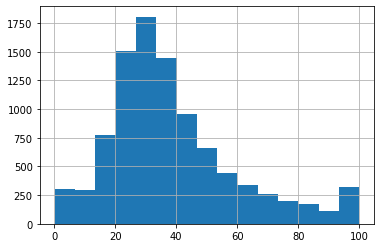

In [30]:
df1['Pawpularity'].hist(bins=15)

<AxesSubplot:>

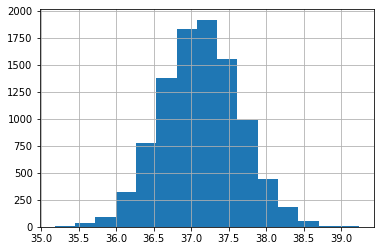

In [31]:
df2['Pawpularity'].hist(bins=15)

In [32]:
df2.rename({'Pawpularity': 'Swin_conv', 'Id': 'Id_conv'}, axis='columns', inplace = True)
df2.head()

,Unnamed: 0,Id_conv,Swin_conv
0,0,0007de18844b0dbbb5e1f607da0606e0,37.857334
1,1,0009c66b9439883ba2750fb825e1d7db,36.403889
2,2,0013fd999caf9a3efe1352ca1b0d937e,37.115826
3,3,0018df346ac9c1d8413cfcc888ca8246,36.917225
4,4,001dc955e10590d3ca4673f034feeef2,36.632595


In [33]:
features = pd.concat([df1, df2.reindex(df1.index)], axis=1)
features = features.drop(columns = ['Id','Id_conv','Unnamed: 0'])
features.rename({'Pawpularity': 'Resnet_score'}, axis = 'columns', inplace = True)
features.head()

,Resnet_score,Swin_conv
0,45.482555,37.857334
1,44.061150,36.403889
2,25.099745,37.115826
3,58.583961,36.917225
4,74.583145,36.632595


In [34]:
X_train = features[:-20]
X_test = features[-20:]

In [35]:
target = target['Pawpularity']

In [36]:
y_train = target[:-20]
y_test = target[-20:]

# Data preparation for submission

In [37]:
df2_test.rename({'Pawpularity': 'Swin_conv', 'Id': 'Id_conv'}, axis='columns', inplace = True)
df2_test.head()

,Unnamed: 0,Id_conv,Swin_conv
0,0,4128bae22183829d2b5fea10effdb0c3,35.931435
1,1,43a2262d7738e3d420d453815151079e,36.882275
2,2,4e429cead1848a298432a0acad014c9d,36.803551
3,3,80bc3ccafcc51b66303c2c263aa38486,36.091537
4,4,8f49844c382931444e68dffbe20228f4,37.088703


In [38]:
features_test = pd.concat([df1_test, df2_test.reindex(df1_test.index)], axis=1)
features_test = features_test.drop(columns = ['Id','Id_conv','Unnamed: 0'])
features_test.rename({'Pawpularity': 'Resnet_score'}, axis = 'columns', inplace = True)
features_test.head()

,Resnet_score,Swin_conv
0,32.164581,35.931435
1,32.796482,36.882275
2,34.673153,36.803551
3,32.564430,36.091537
4,32.691185,37.088703


# Training

Coefficients: 
 [0.92853949 0.2365062 ]
RMSE: 3.48
Coefficient of determination: 0.93


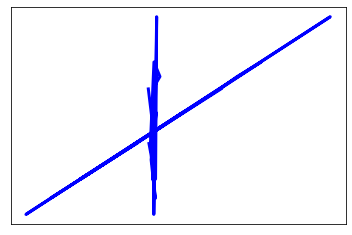

In [39]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred,squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
#plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [40]:
y_pred

array([48.5945431 , 39.08886744, 23.4044324 , 42.09575962, 29.01603889,
       23.99669616, 36.21287216, 42.58755745, 28.85676705, 18.10661503,
       34.05544077, 56.08837048, 52.03362143, 49.10374533, 33.92824463,
       28.2601197 , 13.66274902, 68.68625792, 23.48383097, 33.3930672 ])

# Submission

In [41]:
y_pred = regr.predict(features_test)

In [42]:
y_pred

array([31.8045299 , 32.61615429, 34.34009858, 32.21367075, 32.56720341,
       32.48042582, 32.59430576, 33.18301927])

In [43]:
target_test['Pawpularity'] = y_pred

In [44]:
target_test.to_csv('submission.csv', index=False)

In [45]:
import eli5
from eli5.sklearn import PermutationImportance

In [46]:
feature_names = list(X_train.columns)

In [47]:
perm = PermutationImportance(regr).fit(X_test, y_test)
eli5.show_weights(perm,top=50,feature_names = feature_names)

Weight,Feature
2.1181 ± 0.6022,Resnet_score
0.0008 ± 0.0021,Swin_conv


In [48]:
eli5.explain_weights(regr, top=40, feature_names = feature_names)

Weight?,Feature
+0.929,Resnet_score
+0.237,Swin_conv
-6.560,<BIAS>
